## Podcast Advertisement - Dimesion Reduction - CLustering 
### Adam McWilliams
### Github Repo: https://github.com/cu-cspb-4622-summer-2023/p2-adamjmcwilliams
---
## Project Topic

This project works in conjunction with a seperate project that I am currently working on that clusters/organizes a catalog of podcast episodes by topic. This seperate project requires podcast descriptions that are clean of all advertisements else the topic modeling gets thrown off. I am currently trying to build a supervised model that can detect wether an embedding in the description contains advertising, if it does the model will flag that embedding for removal. I have found a relatively small dataset that consists of podcast descriptions where each sentence is labeled 1 for and advertising or 0 for a non-advertisement. I want to build upon this dataset so that I can build a more robust model. This dataset is used by a model on huggingface that performs this exact function, but it is extremely slow. I also have suspicions that the dataset is not well balanced.

For this current project I will be using unsupervised methods to reduce the dimensions of all sentence embeddings and run a clustering algorithm on the dataset to understand the nuances and representation of how "advertisements" are expressed in the data. This will give me insight into what kind of advertisements are well represented in the dataset and what kind of expressions of advertising I need to collect to create a more balanced and robust dataset for detecting podcast advertising. If I find that a particular cluster is not well represented I can actively seek out that data in the future to add to the dataset.

---

## Data

Here is the link to the dataset [Podcast Description Dataset](https://github.com/MorenoLaQuatra/MATeR/blob/main/description_sentences_classification.tsv)

There are 3 columns. The first is the text representation of a single sentence in the podcast description. The second is the spotify id of the podcast episode. The third is a binary representation of wether the sentence contains advertising.

There are 2203 entries and the file is of size 261 kb

---

## Data Cleaning

First things first I need to convert all the sentences into embeddings before I can perform any kind of statistical analysis.  I am going to be using the OpenAI embedding api to transform each sentence. By transforming each sentence to an embedding we are creating a numerical representation of the textual data. This process will capture the semantic similarities between sentences. Text with similar meaning will be closer in the vector space. There are many libraries that can convert text to embeddings that work for this problem, but I know the OpenAI embedding models are robust and reliable. If I was doing topic modeling I would remove stop words, but I think I am going to leave them in just because they might be important in identifying certain phrases contained in advertising.  

 This code below is unrelated to the class, but I am just basically accessing my api secrets from the cloud and then running batches off 500 sentences per request. Once I have all of my embeddings I will save them in a dataframe under column "embedding". I have also saved all the columns in the original dataset in the same dataframe.

In [1]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import boto3
from botocore.exceptions import ClientError
import json
import pandas as pd

def get_secret(key_name):
    secret_name = "bertopic_pcast_secrets"
    region_name = "us-east-1"

    # Create a Secrets Manager client
    try:
        session = boto3.session.Session()
    except Exception as e:
        raise e
    
    
    client = session.client(
        service_name='secretsmanager',
        region_name=region_name
    )

    print("Initialized Client")
    try:
        get_secret_value_response = client.get_secret_value(
            SecretId=secret_name
        )
    except ClientError as e:
        # For a list of exceptions thrown, see
        # https://docs.aws.amazon.com/secretsmanager/latest/apireference/API_GetSecretValue.html
        raise e

    # Decrypts secret using the associated KMS key.
    secret = get_secret_value_response['SecretString']
    secret_json = json.loads(secret)
    return secret_json.get(key_name)


In [2]:
df = pd.read_csv("description_sentences_classification.tsv",
                sep="\t", names=["isAd", "episodeId", "sentence"])

In [3]:
from sentence_transformers import SentenceTransformer
from openai import OpenAI
client = OpenAI(api_key=get_secret("OPENAI_KEY"))

def embeddings_request(sentences_batch, embeddings):
    response = client.embeddings.create(
            input=sentences_batch,
            model="text-embedding-3-small"
    )

    for obj in response.data:
            embeddings.append(obj.embedding)

    return embeddings
    
def get_embeddings(sentences):
    BATCH_SIZE = 500
    start = 0
    end = BATCH_SIZE
    embeddings = []
    while True:
        sentences_batch = sentences[start:end].tolist()
        embeddings = embeddings_request(sentences_batch, embeddings)

        start = end
        if end + BATCH_SIZE > len(sentences):
            end = len(sentences)
            embeddings = embeddings_request(sentences[start:end].tolist(), embeddings)
            break
        end += BATCH_SIZE

    
    #model = SentenceTransformer('all-MiniLM-L6-v2')
    #embedding = model.encode(sentences, show_progress_bar=True)  
    return embeddings

embeddings = get_embeddings(df['sentence'])
df["embedding"] = embeddings

C:\Users\adamj\AppData\Roaming\Python\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Initialized Client


Now I can save this dataframe to a csv file so I do not need to keep paying for the api requests.

In [4]:
df.to_csv("advertisement_embeddings.csv", index=False)

In [1]:
import pandas as pd
df = pd.read_csv("advertisement_embeddings.csv")

After reading the embeddings back from the csv file they are in string format. We now need to convert the strings into numpy arrays so they are compatible with the models we will be using.

In [2]:
print(type(df['embedding'].iloc[0]))

<class 'str'>


In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from ast import literal_eval
import numpy as np


df['embedding'] = df['embedding'].apply(lambda x: literal_eval(x))
df['embedding'] = df['embedding'].apply(lambda x: np.array(x))

Here we can check if the embeddings are the correct type. We will also calculate the number of dimensions for each embedding. They will all be the same size.

In [17]:
dimensions = len(df['embedding'].iloc[0])
print(f"Dimensions: {dimensions}")


Dimensions: 1536


## EDA and Model Choice

Now I want to make sure the advertisements and non-advertisements are linearly seperable. If they are then I know we can draw a linear boundary in the feature space to distinguish between our two classes and I can simplify the space by removing non-advertisements. If they are not easily separable then we can be convinced this dataset is of poor quality and I am in big trouble.

For the first test I will run logistic regression on the dataset. If we have a high accuracy score we can be assured that the dataset is linearly separable between both classes. 

In [18]:
def log_reg_fit(X_train, y_train):
    log_reg = LogisticRegression(max_iter=1000) 
    log_reg.fit(X_train, y_train)
    return log_reg

def log_reg_predict(log_reg, X_test, y_test):
    y_pred = log_reg.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.4f}")
    print(classification_report(y_test, y_pred))

In [19]:
X_train, X_test, y_train, y_test = train_test_split(df['embedding'], df['isAd'], test_size=0.2, random_state=42)
log_reg = log_reg_fit(np.stack(X_train.values), y_train)
log_reg_predict(log_reg, np.stack(X_test.values), y_test)


Accuracy: 0.9546
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       278
           1       0.96      0.91      0.94       163

    accuracy                           0.95       441
   macro avg       0.96      0.95      0.95       441
weighted avg       0.95      0.95      0.95       441



Good we have a high accuracy score. Just to make sure there is a clear distinction in the classes i will reduce the embeddings to two dimensions and plot the embeddings. The points in red represent advertisements and the points in blue represent non-advertisements.

In [20]:
from sklearn.decomposition import PCA

embeddings = np.stack(df['embedding'].values)
embeddings_ads = np.stack(df[df['isAd'] == 1]['embedding'].values)
pca = PCA(n_components=2, svd_solver='auto')
pca_reduced_embeddings = pca.fit_transform(embeddings)
pca_reduced_embeddings_ads = pca.fit_transform(embeddings_ads)

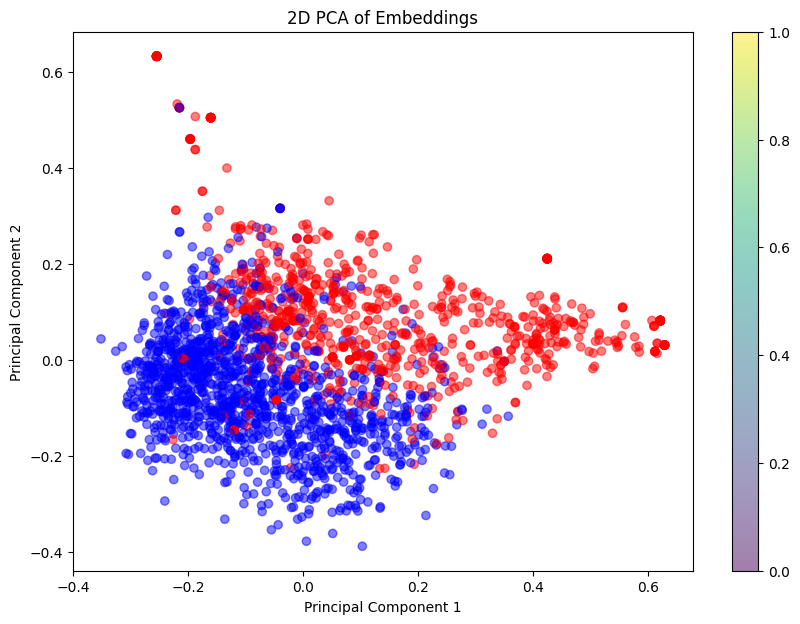

In [21]:
import matplotlib.pyplot as plt

colors = ['red' if label == 1 else 'blue' for label in df['isAd']]
plt.figure(figsize=(10, 7))  # Adjust the figure size as needed
plt.scatter(pca_reduced_embeddings[:, 0], pca_reduced_embeddings[:, 1], c=colors, alpha=0.5)

plt.xlabel('Principal Component 1')  # X-axis label
plt.ylabel('Principal Component 2')  # Y-axis label
plt.title('2D PCA of Embeddings')  # Plot title

plt.colorbar()  
plt.show()

The code below is the same plot without the non-advertising entries.

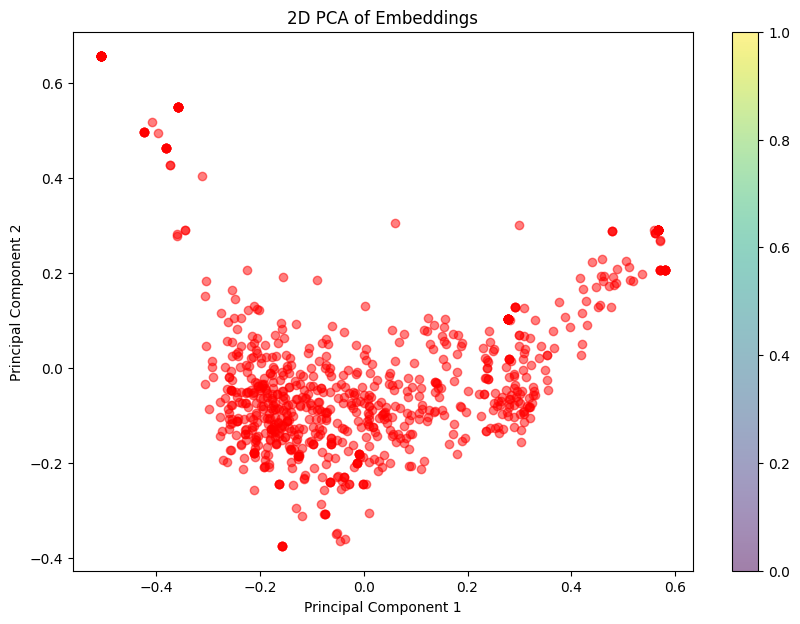

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))  # Adjust the figure size as needed
plt.scatter(pca_reduced_embeddings_ads[:, 0], pca_reduced_embeddings_ads[:, 1], c='red', alpha=0.5)

plt.xlabel('Principal Component 1')  # X-axis label
plt.ylabel('Principal Component 2')  # Y-axis label
plt.title('2D PCA of Embeddings')  # Plot title



plt.colorbar()  
plt.show()

The code below uses a different dimension reduction technique called UMAP that I will explain later in my model building section. I created this additional plot to see if there are more well defined clusters in the data when using this technique.

In [24]:
import umap 

umap_reducer = umap.UMAP( n_neighbors=15, n_components=2, metric='cosine')
umap_reduced_embeddings_ads = umap_reducer.fit_transform(embeddings_ads)

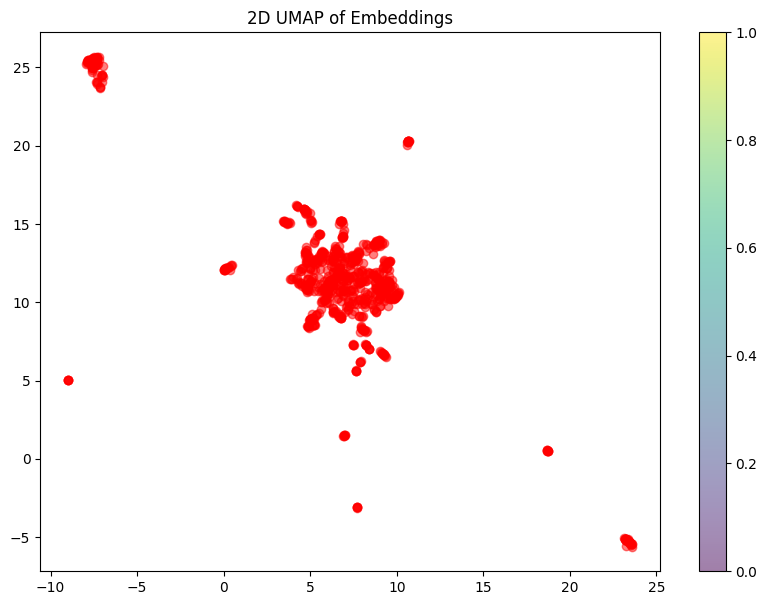

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))  # Adjust the figure size as needed
plt.scatter(umap_reduced_embeddings_ads[:, 0], umap_reduced_embeddings_ads[:, 1], c='red', alpha=0.5)


plt.title('2D UMAP of Embeddings')  # Plot title


plt.colorbar() 
plt.show()

## EDA and Model Choice Conclusions

When looking at the first plot where both classes are projected we can see that there is a pretty clear decision boundary. The accuracy score from the logistic regression model along with this plot is a great sign and gives me confidence that the dataset is well labeled. For my models below I will only be clustering my embeddings containing advertising.

From my research UMAP is more commonly used when reducing the dimensions of embeddings. UMAP is a dimensional reduction algorithm that is more effective at capturing both local and global structures contained in the higher dimensional data after it is reduced. UMAP can also capture non-linear structures where PCA is not as effective. When comparing the PCA and UMAP dimisional reduction plots I do like how UMAP has more well defined clusters. Even in the big cluster you can see denser micro-clusters that might be more apparent with more hyperparameter tuning. I will be using UMAP in my model below.

I'm assuming there will be a lot of noise in the dataset which might make it hard to produce meaningful clusters with most clustering methods. My solution would benefit from a clustering method that identifies clusters of varying densities and size as well as identifying outliers. The clustering method HBDSCAN works by building a hierarchy of clusters based on density and then subsequently pruning the hierarchy to find the most stable clusters. As opposed to a method like KNN this method can identify outliers and does not rely on clusters that need to be the same size and density. Most importantly with HBDSCAN you do not need to specify the number of clusters upfront which make training much more flexible and performant. For these reasons I will be using HBDSCAN for my clustering method.



---

## Model Training

Below I am training both my UMAP and HBDSCAN models. I am using standard gridsearch to tune my hyperparameters.

The 3 parameters I have chosen to tune are based on the influence they have on the resulting clusters.

n_components: Specifies the number of dimensions UMAP will reduce the data to.

n_neighbors: This parameter dictates the number of neighboring sample points that are used when making the manifold approximation. A higher value results in a more global structure of the embeddings while a smaller value results in a more local structure of the original embedding. A higher n_neighbors results in less micro clusters being generated.

min_cluster_size: This dictates the min number of samples allowed per cluster. A higher value will result in less clusters and a lower value will most likely result in more clusters

I will explain the metric siloutte score below.

In [26]:
import hdbscan
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import silhouette_score

param_grid = {
    'n_components': [5, 10, 15, 20],
    'n_neighbors': [5, 10, 15, 20],
    'metric': ['cosine'],
    'min_cluster_size': [5, 10, 15, 20, 25, 30]
}


best_score = -1
best_model = None
best_params = None
best_labels = None
results = []

def fit_predict_hbdscan(params, embeddings):
    clusterer = hdbscan.HDBSCAN(min_cluster_size=params['min_cluster_size'], gen_min_span_tree=False)
    
    labels = clusterer.fit_predict(embeddings)
    if len(set(labels)) > 1:
        score = silhouette_score(embeddings, labels) 

    results.append({
        'n_neighbors': params['n_neighbors'],
        'n_components': params['n_components'],
        'min_cluster_size': params['min_cluster_size'],
        'silhouette_score': score
    })

    return score, labels

for params in ParameterGrid(param_grid):
    reducer = umap.UMAP(n_components=params['n_components'], n_neighbors=params['n_neighbors'], metric=params['metric'])
    reduced_embeddings = reducer.fit_transform(embeddings_ads)
    score, labels = fit_predict_hbdscan(params, reduced_embeddings)
    print("1 model processed")
    if score > best_score:
        best_model_type = "UMAP"
        best_model = reducer
        best_embeddings = reduced_embeddings
        best_score = score
        best_params = params 
        best_labels = labels


1 model processed
1 model processed
1 model processed
1 model processed
1 model processed
1 model processed
1 model processed
1 model processed
1 model processed
1 model processed
1 model processed
1 model processed
1 model processed
1 model processed
1 model processed
1 model processed
1 model processed
1 model processed
1 model processed
1 model processed
1 model processed
1 model processed
1 model processed
1 model processed
1 model processed
1 model processed
1 model processed
1 model processed
1 model processed
1 model processed
1 model processed
1 model processed
1 model processed
1 model processed
1 model processed
1 model processed
1 model processed
1 model processed
1 model processed
1 model processed
1 model processed
1 model processed
1 model processed
1 model processed
1 model processed
1 model processed
1 model processed
1 model processed
1 model processed
1 model processed
1 model processed
1 model processed
1 model processed
1 model processed
1 model processed
1 model pr

## Results and Analysis:

Evaluation Metric:

I chose the silhouette score to incentivize the labeling of dense, compact, and highly related clusters. In essence it calculates how similar a data point is to it's own cluster as opposed to other clusters. A high score indicates the cluster is clear and distinct while a low score indicates clusters are overlapping. This works well in my case because I want to cluster the advertisements with semantic meaning and words that are the most similar within it's own cluster. This will allow me to indicate what forms of ads are under-represented or over-represented in my dataset.

Below is the best sillhoute score and the best parameters evaluated from the parameter search tuning.

In [27]:
print(f"best_score: {best_score}")
print(f"n_neighbors: {best_params['n_neighbors']}")
print(f"min_cluster_size: {best_params['min_cluster_size']}")
print(f"n_components: {best_params['n_components']}")

n_neighbors: 20
min_cluster_size: 20
n_components: 5


Below I created a similarity matrix to understand which parameters impact the silhoutte score the most.

In [28]:
results = pd.DataFrame(results)
corr_matrix = results.corr()

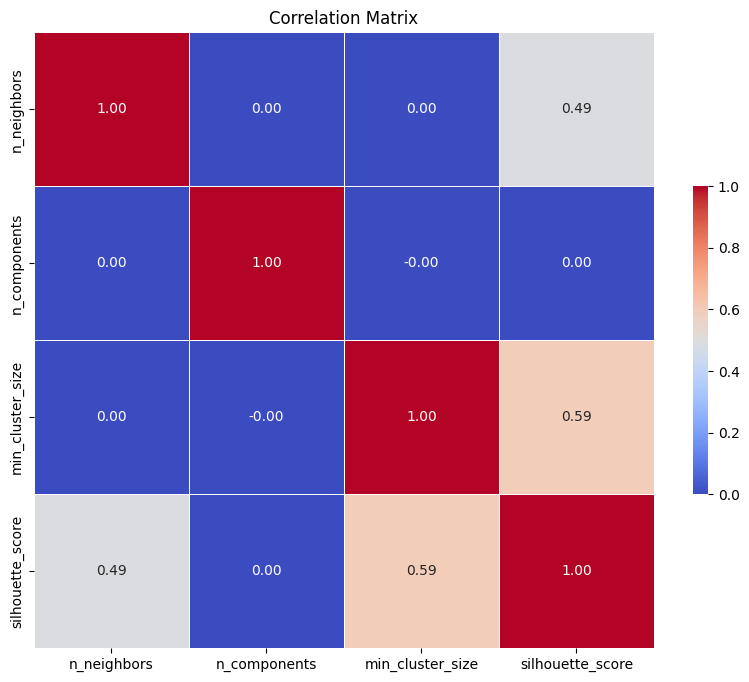

In [29]:
import seaborn as sns
plt.figure(figsize=(10, 8))

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, cbar_kws={"shrink": .5})

plt.title('Correlation Matrix')

plt.show()

As we can see n_components is not as impactful on the score as compared to parameters like n_neighbors and min_cluster_size. This works out because we know that if we reduce the dimensions to 2d it will not influence our evaluation metric. Therefore we can easily visualize the model within 2d. Below I have created a new model with ideal parameters and n_components equal to 2. I then plotted the results. I removed the outliers from the plot to hopefully reduce noise.

In [ ]:
reducer = umap.UMAP(n_components=2, n_neighbors=best_params['n_neighbors'], metric=best_params['metric'])
reduced_embeddings = reducer.fit_transform(embeddings_ads)
clusterer = hdbscan.HDBSCAN(min_cluster_size=best_params['min_cluster_size']
                            , gen_min_span_tree=False)
labels = clusterer.fit_predict(reduced_embeddings)

C:\Users\adamj\AppData\Local\Temp\ipykernel_5068\2249522144.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('Spectral', len(unique_labels))


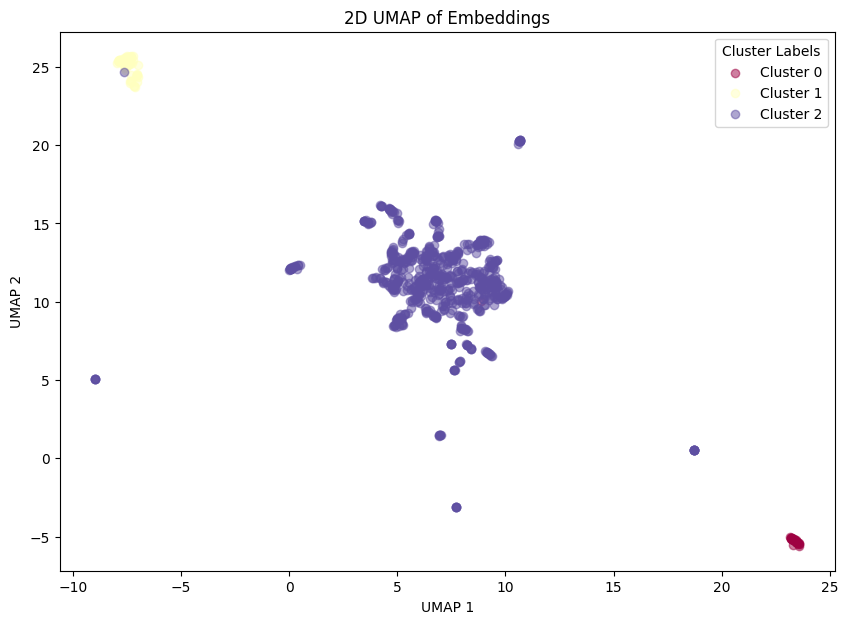

In [35]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 7))

unique_labels = np.unique(best_labels[best_labels != -1])

color_map = plt.cm.get_cmap('Spectral', len(unique_labels))

for label in unique_labels:
    index = labels == label
    plt.scatter(umap_reduced_embeddings_ads[index, 0], umap_reduced_embeddings_ads[index, 1], color=color_map(label - min(unique_labels)), label=f'Cluster {label}', alpha=0.5)

plt.title('2D UMAP of Embeddings')
plt.xlabel('UMAP 1')  # Optional: label for x-axis
plt.ylabel('UMAP 2')  # Optional: label for y-axis

# Show the legend
plt.legend(title="Cluster Labels", loc='best')

plt.show()

Now to really understand the clusters I need to convert the clustered embeddings back to sentences and use my mind to understand what is happening. In the code below I find the center of each cluster and then capture the 5 sentences that are the closest to the center of each cluster. These 15 sentences should be the most representative sentences for each cluster.

In [41]:
unique_labels = np.unique(best_labels)

label_indices = {}

for label in unique_labels:
    indices = np.where(best_labels == label)[0]
    label_indices[label] = indices

cluster_centers = {}

# Iterate over each unique label to calculate the cluster center
for label in unique_labels:
    cluster_embeddings = reduced_embeddings[best_labels == label]
    center = np.mean(cluster_embeddings, axis=0)
    cluster_centers[label] = center

from scipy.spatial import distance

closest_points_indices = {}

for label, center in cluster_centers.items():
    cluster_embeddings = reduced_embeddings[best_labels == label]
    # Calculate the distances of all points in the cluster to the cluster center
    distances = distance.cdist([center], cluster_embeddings, 'euclidean')[0]
    # Get the indices of the 5 closest points
    closest_indices = np.argsort(distances)[:5]
    original_indices = np.where(best_labels == label)[0][closest_indices]
    closest_points_indices[label] = original_indices

sentences_ads = df[df['isAd'] == 1]['sentence']

for label, indices in closest_points_indices.items():
    print(f"Cluster {label}:")
    for index in indices:
        print(sentences_ads.iloc[index])
    print("\n")  

Cluster 0:
---   This episode is sponsored by  · Anchor: The easiest way to make a podcast.  https://anchor.fm/app
---   This episode is sponsored by  · Anchor: The easiest way to make a podcast.  https://anchor.fm/app
---   This episode is sponsored by  · Anchor: The easiest way to make a podcast.  https://anchor.fm/app  Support this podcast: https://anchor.fm/carterfarrpodcast/support
Michael Cole- This episode was released during Legends and Icon month- enjoy his story about how it all got started.   ---   This episode is sponsored by  · Anchor: The easiest way to make a podcast.  https://anchor.fm/app
---   This episode is sponsored by  · Anchor: The easiest way to make a podcast.  https://anchor.fm/app


Cluster 1:
_
_
_
_
_


Cluster 2:
Link in my instagram bio to listen @the_plantbased_coach
Want to join a Community?
Join our Secret FB Group by searching MOMHOOD on Facebook
Facebook Page: @DopeBlackDads  If you want to get in touch with us
To find our more visit justbreatheproje

Cluster 0:
It looks like the first cluster represents a paid ad that was contained in multiple descriptions. 

Cluster 1:
Cluster 1 captured special characters that were labeled as ads for whatever reason in the dataset. I will eventually remove this cluster from my dataset.

Cluster 2:
Cluster 2 is the largest and most likely contains many micro-clusters that can be further refined.

I can keep running the same process iteratively excluding certain cluster, refining the dataset and performing UMAP and HBDSCAN to understand and seek new descriptions that balance the dataset. I am going to leave this here as a proof of concept and continue at a further date.

---

## Discussion and Conclusion

Overall I would say this was a successful project. In order to find advertisements that are underrepresented I could build supervised models on underrepresented clusters and match them with embeddings discovered on the spotify api. This way I can build a more robust and balanced dataset to accurately classify sentences.

I think that for any clustering algorithm evaluating a metric that represents performance is extremely subject and tricky. The silhouette score is great at identifying dense clusters but there is really nothing that compares to using your eyes, visualizing plots, and reading the sentences that were classified. I think that in the future I could build a more user friendly system makes it easier to adjust hyperparameter and manually evaluate clusters. 

Another improvement would be making this code more modular and reusable. Refactoring the code into a class that handles iterative training sessions would be useful. I believe HBDSCAN allows you to view the entire hierarchical tree which would be extremely useful for quickly observing the cluster formation at different levels of granularity.